<a href="https://colab.research.google.com/github/DotunOluyade/ShootingVideoClassifier/blob/main/VideoAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Real-Time Crime Prevention using Video Anomaly Detection




Comparative Analysis of Pretrained Video Classification models in detecting real-time shooting crime for peace and safety

## Data Collection

A sub-set of UCF-Crime dataset is used for this research work. It contains 128 hours of video, comprising 1900 long untrimmed real world surveillance videos, with 13 realistic anomalies as well as normal activities (Sultani et al., *2018*).

This research uses the shooting dataset only to fine-tune selected video classification pretrained models, compares and evaluate their performance.

### Specify Dataset Location

Import package dependencies and define variables for datasets and pretrained model.

Video Swim a pure transformer based video modeling algorithm with its pretrained model is used for feature extraction and fine-tuned with the shooting dataset for classifying videos as shooting or non shooting videos (Liu et al.,2022).



In [78]:
#from google.colab import drive
#drive.mount('/content/drive')


!cp -r "/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/" "/content/Small_Anomaly/"

!cp -r "/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/" "/content/Small_Normal/"


!ls "/content/Small_Anomaly/"
!ls "/content/Small_Normal/"


Shooting003_x264.mp4  Shooting006_x264.mp4  Shooting012_x264.mp4  Small_Anomaly
Shooting004_x264.mp4  Shooting007_x264.mp4  Shooting013_x264.mp4
Shooting005_x264.mp4  Shooting009_x264.mp4  Shooting014_x264.mp4
Normal_Videos001_x264.mp4  Normal_Videos007_x264.mp4  Normal_Videos012_x264.mp4
Normal_Videos002_x264.mp4  Normal_Videos008_x264.mp4  Normal_Videos013_x264.mp4
Normal_Videos004_x264.mp4  Normal_Videos009_x264.mp4  Small_Normal
Normal_Videos005_x264.mp4  Normal_Videos011_x264.mp4


In [79]:
import cv2
import os
import shutil
import pandas as pd
import shutil
import numpy as np
from sklearn.utils import shuffle as sk_shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
import glob
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.metrics import Precision, Recall, AUC
import pandas as pd
from IPython.display import HTML, display
import time
import gc




base_directory = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/'
normal_dir = '/content/Small_Normal/'
anomaly_dir = '/content/Small_Anomaly/'
anomaly_text_file = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Anomaly_Train.txt'
anomaly_train = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/UCF_Crimes-Train-Test-Split/Anomaly_Detection_splits/Anomaly_Train.txt'

saved_model_path = '/content/drive/MyDrive/VideoAnomalyDetection/pretrained/Video Swin Transformer/TFVideoSwinB_K600_IN22K_P244_W877_32x224'

# Data Preprocessing

Resize, normalize and split videos into frames. Batch frames in 32 segments.

Use data generators to prevent loading large datset into memory at once, to better utilize memory for resource constrained environement.

Generator loads and preprocess 32 frames at each interval.

In [80]:
import cv2
import numpy as np

def preprocess_and_segment_video(video_path, resize_shape=(224, 224), segment_length=32):
    """
    Generator to preprocess raw videos by resizing, converting color space, and normalization.

    Parameters:
    - video_path: absolute path to video file.
    - resize_shape: shape (width, height) to resize video frames to.
    - segment_length: number of frames to include in each segment (batch).

    Yields:
    - Segments of preprocessed video frames of shape (32, 224, 224, 3).
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Warning: Could not open video file {video_path}")
        yield None  # Or raise an exception
        return

    frames_count = 0
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # No more frames or error
        frame = cv2.resize(frame, resize_shape)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
        frames.append(frame)
        frames_count += 1

        # Yield a batch when enough frames are collected
        if frames_count == segment_length:
            print("Generator yielding {} frames for video {}".format(frames_count, video_path))
            yield np.stack(frames, axis=0)  # Stack frames to create a segment
            frames_count = 0
            frames.clear()
    cap.release()

    # Handle the last batch if it has fewer frames than segment_length
    if frames_count > 0:
        # Optionally pad the last batch to reach the desired segment length
        while frames_count < segment_length:
            frames.append(np.zeros(resize_shape + (3,), dtype=np.float32)) # Pad
            frames_count += 1
        yield np.stack(frames, axis=0)




#for batch in preprocess_and_segment_video("/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting001_x264.mp4"):
#    if batch is not None:
#        print(batch.shape)  # Should print (32, 224, 224, 3) for full batches


## Data Augmentation

The dataset between normal videos and the anomalous shooting dataset is inbalance and impacts on model performance. To resolve this, data augmentation technique is introduces to increase the shooting dataset by transforming extracted shooting images using cropping, shadowing, blurring on existing images.

### Video Processing Utilities

In [81]:
"""
Note: Changed 'train_size' argument to 'train_size_ratio' to avoid confusion with the calculated 'train_size' variable.
"""
def list_video_files(directory, extension='mp4'):
    """
    List all video files in the given directory with the specified extension.

    Parameters:
    - directory: Path to the directory to search for video files.
    - extension: Extension of the video files to search for (default is '*.mp4').

    Returns:
    - A list of paths to the video files found.
    """
     # Check if the directory exists
    if not os.path.exists(directory):
        print(f"Error: Directory does not exist - {directory}")
        return []  # Return an empty list instead of None

    # Check if the directory can be accessed (read permissions)
    if not os.access(directory, os.R_OK):
        print(f"Error: Directory cannot be read, check permissions - {directory}")
        return []  # Return an empty list instead of None

    # Perform a recursive search for video files
    pattern = os.path.join(directory, '**', f'*.{extension}')
    _video_files = glob.glob(pattern, recursive=True)
    return _video_files


def shuffle_together(video_paths, label):
    """
    Shuffle two lists in unison.

    Parameters:
    - video_paths: The first list to shuffle.
    - label: The second list to shuffle, must be the same length as list1.

    Returns:
    - The shuffled video_paths and label.
    """
    if len(video_paths) != len(label):
        raise ValueError("The lists to be shuffled must be the same length.")

    # sklearn's shuffle function to shuffle both lists in unison
    video_paths_shuffled, label_shuffled = shuffle(video_paths, label)
    return video_paths_shuffled, label_shuffled

def get_total_frames(video_path):
    """
    Returns the total number of frames in a video.

    Parameters:
    - video_path: The path to the video file.

    Returns:
    - The total number of frames as an integer.
    """
    # Initialize the video capture object with the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video file: {video_path}")
        return 0  # Indicates that the video could not be opened

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Release the video capture object
    cap.release()

    return total_frames
"""
video_path = "/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting001_x264.mp4"
frame_total = get_total_frames(video_path)
print("Total frames per video",frame_total )
"""


def calculate_total_segments(video_paths, segment_length=32):
    total_segments = 0
    for video_path in video_paths:
        total_frames = get_total_frames(video_path)  # This function needs to return the total frame count

        if total_frames is None or total_frames == 0:
            print(f"Skipping {video_path}, no frames.")
            continue

        segments = total_frames // segment_length
        if total_frames % segment_length != 0:
            segments += 1  # Account for the last, potentially shorter, segment
        total_segments += segments

    return total_segments


# Example usage

#video_paths = [
#    "/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting001_x264.mp4"]
#total_segments = calculate_total_segments(video_paths, segment_length=32)
#print(f"Total segments: {total_segments}")



#Generate Features and Labels

In [85]:

def create_dataset_from_videos(video_paths, labels, resize_shape=(224, 224), segment_length=32):
    """
    Creates a TensorFlow dataset of video segments with corresponding labels.

    Args:
        video_paths (list of str): Paths to video files.
        labels (list of int): Labels for each video file.
        resize_shape (tuple): The target shape for resizing frames.
        segment_length (int): Number of frames per video segment.

    Returns:
        tf.data.Dataset: A dataset of video segments and labels.
    """
    def generator():
        count = 0;
        for video_path, label in zip(video_paths, labels):
            count = count + 1;
            video_gen = preprocess_and_segment_video(video_path, resize_shape, segment_length)
            print("Video files count: {} processing: {}".format(count, video_path))
            # Iterate over the generator and yield its items
            for segment in video_gen:  # Iterate over items yielded by video_gen
                yield segment, label
            """
            if features is not None:
                # Yield features and label if processing was successful
                yield features, label
            else:
                print(f"Skipping video {video_path}, unable to process.")
            """
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(segment_length, *resize_shape, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )


# Assuming implementations for list_video_files and shuffle_together
anomaly_videos, normal_videos = list_video_files(anomaly_dir), list_video_files(normal_dir)
print("anomaly_videos", len(anomaly_videos))
print("normal_videos", len(normal_videos))

video_paths = anomaly_videos + normal_videos
labels = [1] * len(anomaly_videos) + [0] * len(normal_videos)

dataset = create_dataset_from_videos(video_paths, labels)

#for features, label in dataset.take(3):
#    print("Features shape:", features.numpy().shape)

#    print("Labels:", label.numpy())
total_segments = sum(1 for _ in dataset)

#print("Total segments: ", dataset_size)

# calculate the total video segments
#total_segments = int(calculate_total_segments(video_paths))

print("Total segments: ", total_segments)

# Calculate split sizes
train_size = int(total_segments * 0.8)
val_size = total_segments - train_size  # Optionally, to ensure the entire dataset is used

# Ensure dataset is shuffled (use actual total size if known for better shuffling, uses more memory)
dataset = dataset.shuffle(buffer_size=1057)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

#for features, label in train_dataset.take(1):
#    print("Train: Labels:", label.numpy())
#    print("Train: Features shape:", features.numpy().shape)

#for features, label in val_dataset.take(1):
#    print("Val: Features shape:", features.numpy().shape)
#    print("val: Labels:", label.numpy())


anomaly_videos 19
normal_videos 20
Video files count: 1 processing: /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anom

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: `generator` yielded an element of shape () where an element of shape (32, 224, 224, 3) was expected.
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape () where an element of shape (32, 224, 224, 3) was expected.


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

# Fine-Tune A Pretrained Video Swin Transformer Model for Video Classification

In [72]:

def build_finetune_model():
    """
    Fine tune pretrained model

    Returns:
        model (Fine-tuned for shooting classification)
    """
   # import pretrained model, i.e.
    video_swin = keras.models.load_model(saved_model_path, compile= False)
    video_swin.trainable = False

    # Adding sparsity constraint via L1 regularization
    regularizer = regularizers.l1(0.01) #1e-5

    # downstream model
    model = keras.Sequential([
        video_swin,
        # video_swin outputs a 1D tensor of shape (600,)
        layers.Dense(512, activation='relu',activity_regularizer=regularizer),  # # L1 regularization for sparsity
        layers.Dropout(0.5),  # Dropout layer to reduce overfitting
        layers.Dense(1, activation='sigmoid')  # Final Dense layer for binary classification
    ])
    return model


In [73]:
def temporal_smoothness_loss(y_true, y_pred):
    # Custom loss function for temporal smoothness
    smoothness = tf.reduce_mean(tf.abs(y_pred[:,1:] - y_pred[:,:-1]))
    return smoothness


#Train the Fine-Tuned Model for Shooting Classification

In [74]:
# Callbacks configuration
checkpoint_path = "./model_output/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks_list = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=1,
        save_best_only=True,
        monitor='val_loss'),  # Save the best model based on val_loss
    EarlyStopping(
        monitor='val_loss',
        patience=10),  # Stop training when `val_loss` is no longer improving
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5),  # Reduce learning rate when `val_loss` plateaus
    TensorBoard(
        log_dir='./model_output/logs',  # Path to save log files for TensorBoard
        histogram_freq=1,  # Record activation histograms every 1 epoch
        embeddings_freq=1)  # Record embedding data every 1 epoch
]

## Multiple Instance Learning Loss

In [75]:
import tensorflow as tf

def mil_ranking_loss(sparsity_weight=0.01, smoothness_weight=0.01, margin=1.0):
    """
    MIL ranking loss with sparsity and smoothness constraints.

    Args:
    - sparsity_weight: Weight for the sparsity term.
    - smoothness_weight: Weight for the smoothness term.
    - margin: Margin for the ranking loss.

    Returns:
    - A loss function that takes (y_true, y_pred) as inputs.
    """
    def loss(y_true, y_pred):
        # y_ped contains the anomaly scores for the instances,
        # and y_true contains the bag labels (1 for anomalous, 0 for normal).

        # Separate the scores into positive and negative bags based on y_true labels.
        positive_scores = tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))
        negative_scores = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))

        # Compute the ranking loss
        highest_positive_score = tf.reduce_max(positive_scores)
        highest_negative_score = tf.reduce_max(negative_scores)
        ranking_loss = tf.maximum(0.0, margin - highest_positive_score + highest_negative_score)

        # Compute sparsity constraint (L1 norm)
        sparsity_loss = tf.reduce_sum(tf.abs(y_pred))

        # Compute smoothness constraint (squared difference between adjacent scores)
        diffs = y_pred[:, 1:] - y_pred[:, :-1]
        smoothness_loss = tf.reduce_sum(tf.square(diffs))

        # Combine the losses
        total_loss = ranking_loss + sparsity_weight * sparsity_loss + smoothness_weight * smoothness_loss
        return total_loss

    return loss

In [77]:
# Split into training and validation data
#train_dataset, val_dataset = create_train_val_datasets(anomaly_dir, normal_dir, train_size=0.8, shuffle_buffer_size=100)

# Batch for memory efficiency
batch_size = 2
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)


_steps_per_epoch = total_segments // batch_size

# Asynchronously fetch batches while model is training
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Only use cache() if memory limits won't be exceeded
#train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
#val_dataset = val_dataset.cache().prefetch(tf.data.AUTOTUNE)


finetune_model = build_finetune_model()
# Compile model with MIL loss, adam optimizer and metrics
finetune_model.compile(
    optimizer='adam',
    loss=mil_ranking_loss(sparsity_weight=0.01, smoothness_weight=0.01),
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

for features, labels in train_dataset.take(1):
    print(features.shape)

# Train the model
history = finetune_model.fit(train_dataset, epochs=10,steps_per_epoch=_steps_per_epoch, verbose=1,
validation_data=val_dataset,callbacks=callbacks_list)


Video files count: 1 processing: /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator yielding 32 frames for video /content/Small_Anomaly/Shooting012_x264.mp4
Generator 

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} TypeError: `generator` yielded an element of shape () where an element of shape (32, 224, 224, 3) was expected.
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape () where an element of shape (32, 224, 224, 3) was expected.


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

# Evaluate Final Model Performance

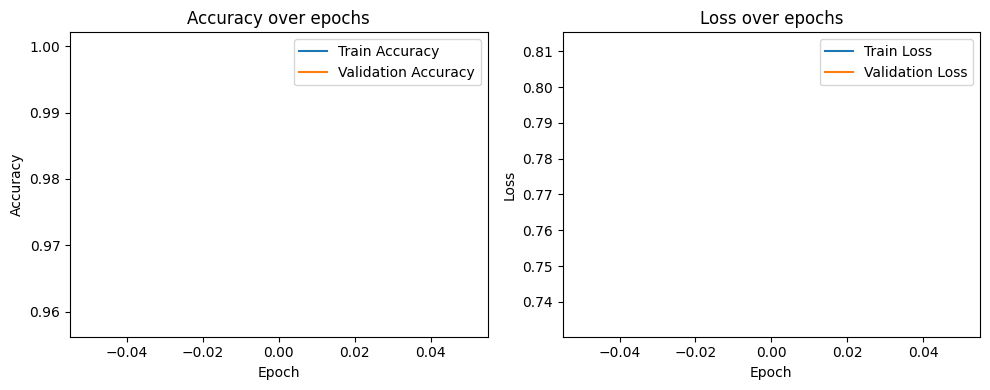

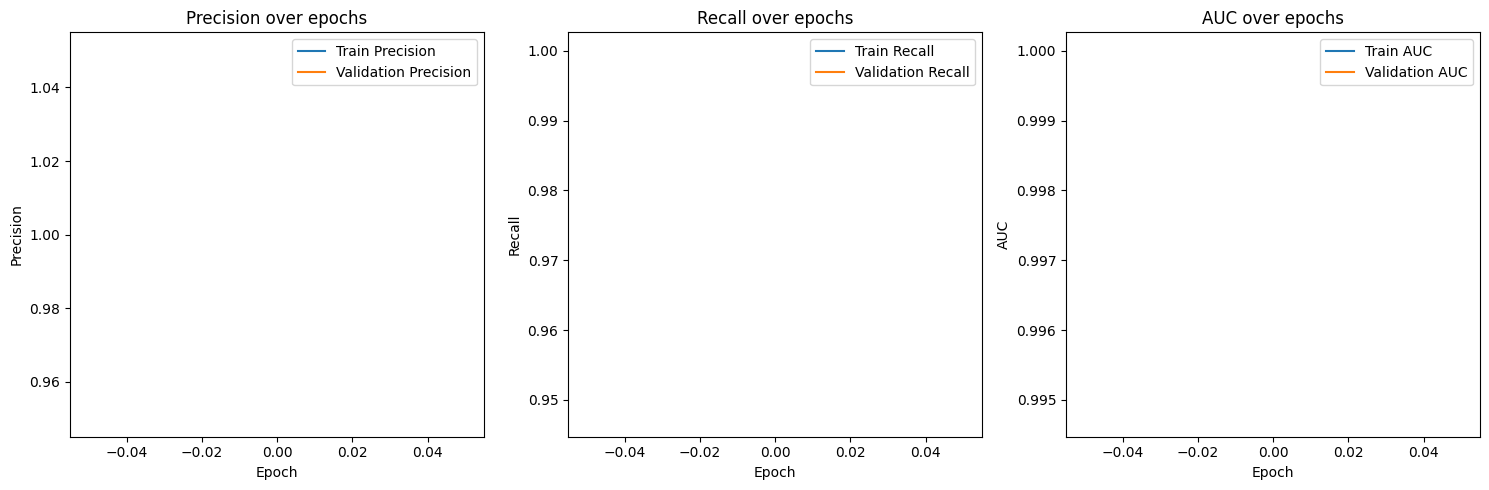

In [74]:
# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot precision, recall, and AUC
plt.figure(figsize=(15, 5))

# Precision
plt.subplot(1, 3, 1)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision over epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall over epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC over epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate the model
#test_loss, test_accuracy, test_precision, test_recall, test_auc = finetune_model.evaluate(test_dataset)
#print(f"Test Metrics:\n Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, AUC: {test_auc}")

# Test Fine-Tuned Model


In [ ]:
# Path to your test video
test_video_path = 'path/to/your/test_video.mp4'

# Preprocess the video
test_video_data = preprocess_test_video(test_video_path)
test_video_data = np.expand_dims(test_video_data, axis=0)  # Add batch dimension

# Load the fine-tuned model
model = tf.keras.models.load_model('path/to/your/fine_tuned_model')

# Make predictions
predictions = model.predict(test_video_data)

# Define an anomaly threshold
anomaly_threshold = 0.5  # This is arbitrary; adjust based on your model and use case

# Check if any segment is predicted as anomalous
is_anomalous = np.any(predictions > anomaly_threshold)

print(f"Video is {'anomalous' if is_anomalous else 'normal'}")


#References:

*   Sultani, W., Chen, C. and Shah, M., 2018. Real-world anomaly detection in surveillance videos. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Available at: https://www.crcv.ucf.edu/research/real-world-anomaly-detection-in-surveillance-videos/ 20/03/2024.
*   Liu, Z., Hu, H., Lin, Y., Yao, Z., Xie, Z., Wei, Y., Ning, J., Cao, Y., Zhang, Z., Dong, L. and Wei, F., 2022. Swin transformer v2: Scaling up capacity and resolution. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. Available at: https://github.com/innat/VideoSwin 20/03/2024
